### STACK GALAXY PAIRS FROM PAIR CATALOG

In [ ]:
import numpy as np
import healpy as hp
from astropy.cosmology import Planck18 as cosmo
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm  # progress bar

# --- Load catalog and map as before ---
# pairs = pd.read_csv('data/galaxy_pairs_catalog_5hmpc.csv')

# --- Settings ---
distance = 20
dataset = "BOSS"
if dataset == "eBOSS":
    pairs_NGC = pd.read_csv(f'data/paircatalogs/galaxy_pairs_catalog_{distance}hmpc.csv')
    pairs_SGC = pd.read_csv(f'data/paircatalogs/galaxy_pairs_catalog_SGC_{distance}hmpc.csv')
    pairs = pd.concat([pairs_NGC, pairs_SGC], ignore_index=True)
elif dataset == "BOSS":
    catalog, region = "CMASS", "North+South"
    pairs_NGC = pd.read_csv(f'data/paircatalogs/galaxy_pairs_catalog_CMASS_North_{distance}_{distance-2}_{distance+2}hmpc.csv')
    pairs_SGC = pd.read_csv(f'data/paircatalogs/galaxy_pairs_catalog_CMASS_South_{distance}_{distance-2}_{distance+2}hmpc.csv')
    pairs = pd.concat([pairs_NGC, pairs_SGC], ignore_index=True)
else:
    raise ValueError("dataset must be eBOSS or BOSS")

alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"
nside = 2048

alm_data = hp.read_alm(alm_file)
lmax = hp.Alm.getlmax(len(alm_data))
kmap = hp.alm2map(hp.smoothalm(alm_data, fwhm=np.radians(8/60)), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

# --- Grid parameters ---
grid_size = 100.0 # Mpc/h box size
grid_res = 101
half_size = grid_size / 2
X_vals = np.linspace(-half_size, half_size, grid_res)
Y_vals = np.linspace(-half_size, half_size, grid_res)
X_grid, Y_grid = np.meshgrid(X_vals, Y_vals)

# Initialize stack accumulators
kappa_stack_sum = np.zeros((grid_res, grid_res))
weight_stack_sum = np.zeros((grid_res, grid_res))

# Loop over all pairs
for idx, pair in tqdm(pairs.iterrows(), total=len(pairs), desc="Stacking pairs"):
    # Extract pair data (convert to radians)
    l1, b1, z1 = np.deg2rad(pair['l1']), np.deg2rad(pair['b1']), pair['z1']
    l2, b2, z2 = np.deg2rad(pair['l2']), np.deg2rad(pair['b2']), pair['z2']

    # --- Enforce consistent ordering of longitudes ---
    # Compute raw difference, wrapped into [-π, π]
    dl_raw = (l2 - l1 + np.pi) % (2*np.pi) - np.pi

    # If "l2 is to the left of l1", swap them
    if dl_raw < 0:
        l1, l2 = l2, l1
        b1, b2 = b2, b1
        z1, z2 = z2, z1
        dl_raw = -dl_raw   # now positive

    # --- Midpoint (wrap-safe) ---
    lc = l1 + 0.5 * dl_raw
    bc = 0.5 * (b1 + b2)
    zbar = 0.5 * (z1 + z2)
    Dc = cosmo.comoving_distance(zbar).value * cosmo.h  # Mpc/h

    # --- Rotation angle θ ---
    dl = dl_raw * np.cos(bc)
    db = (b2 - b1)
    norm = np.hypot(dl, db)
    cos_theta, sin_theta = dl / norm, db / norm

    # Inverse transform (X,Y) -> (l,b)
    dl_cosbc = (cos_theta * (X_grid / Dc)) - (sin_theta * (Y_grid / Dc))
    db_grid = (sin_theta * (X_grid / Dc)) + (cos_theta * (Y_grid / Dc))
    l_grid = lc + dl_cosbc / np.cos(bc)
    b_grid = bc + db_grid

    # Convert to degrees
    l_grid_deg = np.rad2deg(l_grid)
    b_grid_deg = np.rad2deg(b_grid)

    # Convert to Healpix pixels
    l_grid_deg_wrapped = np.mod(l_grid_deg, 360)
    theta = np.radians(90 - b_grid_deg)
    if np.min(theta) < 0:
        print(f"{idx}: Theta less than zero encountered: {np.min(theta)}")
        continue
    if np.max(theta) > np.pi:
        print(f"{idx}: Theta greater than zero encountered: {np.max(theta)}")
        continue
    phi = np.radians(l_grid_deg_wrapped)
    # theta = np.clip(theta, 0, np.pi)  # Ensure valid range
    pix = hp.ang2pix(nside, theta.ravel(), phi.ravel())

    # Sample kappa and mask
    kappa_vals = kmap[pix].reshape(grid_res, grid_res)
    mask_vals = mask[pix].reshape(grid_res, grid_res)

    # Mask out invalid pixels
    valid_mask = (mask_vals != 0) & np.isfinite(kappa_vals)
    kappa_vals[~valid_mask] = 0.0

    # Weights: if you have pair weights, use them here
    weight = 1.0  # equal weighting for now

    # Accumulate weighted sum and weights
    kappa_stack_sum += weight * kappa_vals
    weight_stack_sum += weight * valid_mask.astype(float)

# Avoid division by zero
nonzero = weight_stack_sum > 0
kappa_stack_mean = np.zeros_like(kappa_stack_sum)
kappa_stack_mean[nonzero] = kappa_stack_sum[nonzero] / weight_stack_sum[nonzero]

# Plot stacked map
plt.figure(figsize=(7,7))
extent = [-half_size, half_size, -half_size, half_size]
im = plt.imshow(kappa_stack_mean, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(im, label=r'Stacked $\kappa$')
plt.xlabel('X [Mpc/h]')
plt.ylabel('Y [Mpc/h]')
plt.title(f'Stacked Kappa map from all galaxy pairs {catalog} {region} {distance}Mpc/h')
plt.show()

Stacking pairs:   0%|          | 926/2425676 [00:00<19:23, 2084.67it/s]

589: Theta less than zero encountered: -0.002072813567996257
596: Theta less than zero encountered: -0.009843994234274756
893: Theta less than zero encountered: -0.010412701603513074
894: Theta less than zero encountered: -0.023636641001254698
964: Theta less than zero encountered: -0.045313440472640625


Stacking pairs:   0%|          | 1368/2425676 [00:00<18:45, 2153.18it/s]

1054: Theta less than zero encountered: -0.01906398061221977
1269: Theta less than zero encountered: -0.036512336439097445
1270: Theta less than zero encountered: -0.035836047050269125
1322: Theta less than zero encountered: -0.04067625480414783
1323: Theta less than zero encountered: -0.040423170014808975
1324: Theta less than zero encountered: -0.03497059082137865
1383: Theta less than zero encountered: -0.010715247347283238
1456: Theta less than zero encountered: -0.037641194697091145
1457: Theta less than zero encountered: -0.0414830385723458
1458: Theta less than zero encountered: -0.04156848398842066
1459: Theta less than zero encountered: -0.039607362541257796
1460: Theta less than zero encountered: -0.039958466482871456


Stacking pairs:   0%|          | 1821/2425676 [00:00<18:26, 2189.57it/s]

1583: Theta less than zero encountered: -0.0325259155981373
1584: Theta less than zero encountered: -0.03487241143186656


Stacking pairs:   0%|          | 2493/2425676 [00:01<18:13, 2215.38it/s]

2230: Theta less than zero encountered: -0.007014819132025954
2231: Theta less than zero encountered: -0.028062670183710215
2232: Theta less than zero encountered: -0.039111542995061595
2233: Theta less than zero encountered: -0.041286530665472214
2316: Theta less than zero encountered: -0.009392472721822549
2317: Theta less than zero encountered: -0.02747851609997537
2318: Theta less than zero encountered: -0.04144780593660836
2326: Theta less than zero encountered: -0.004994468100160313
2588: Theta less than zero encountered: -0.010432163833651411


Stacking pairs:   0%|          | 3181/2425676 [00:01<17:51, 2261.86it/s]

2752: Theta less than zero encountered: -0.029722988219413174
2753: Theta less than zero encountered: -0.03785283919405723
2754: Theta less than zero encountered: -0.03882573294687429
2855: Theta less than zero encountered: -0.013717233074760448
2884: Theta less than zero encountered: -0.038922523725942244
2885: Theta less than zero encountered: -0.034189230060994
2886: Theta less than zero encountered: -0.025543600560598363
2887: Theta less than zero encountered: -0.03544284413874965
3054: Theta less than zero encountered: -0.011745072008585726


Stacking pairs:   0%|          | 3860/2425676 [00:01<17:58, 2246.33it/s]

3557: Theta less than zero encountered: -0.042796657289300905
3805: Theta less than zero encountered: -0.04421941554744749
3951: Theta less than zero encountered: -0.017481765005513985


Stacking pairs:   0%|          | 4764/2425676 [00:02<18:04, 2231.95it/s]

4521: Theta less than zero encountered: -0.04183210476135816
4791: Theta less than zero encountered: -0.039623921215253446


Stacking pairs:   0%|          | 5612/2425676 [00:02<24:05, 1674.75it/s]

5559: Theta less than zero encountered: -0.00019352990450789904
5560: Theta less than zero encountered: -0.0091461598815447
5561: Theta less than zero encountered: -0.013651899505069067
5562: Theta less than zero encountered: -0.013220300431383811
5742: Theta less than zero encountered: -0.010223605664223418


Stacking pairs:   0%|          | 6261/2425676 [00:03<27:08, 1485.24it/s]

6054: Theta less than zero encountered: -0.0186274815076488
6055: Theta less than zero encountered: -0.010414015359261572
6056: Theta less than zero encountered: -0.010036751761218661


Stacking pairs:   0%|          | 7276/2425676 [00:03<20:34, 1959.21it/s]

6814: Theta less than zero encountered: -0.02552063270784401
6815: Theta less than zero encountered: -0.021006289071219136
7127: Theta less than zero encountered: -3.124059733843866e-05


Stacking pairs:   0%|          | 7729/2425676 [00:03<19:11, 2098.95it/s]

7359: Theta less than zero encountered: -0.008845903410793157
7360: Theta less than zero encountered: -0.01331448461703195
7519: Theta less than zero encountered: -0.032560838768741225
7520: Theta less than zero encountered: -0.00940070275204408
7572: Theta less than zero encountered: -0.037184958556471026


Stacking pairs:   0%|          | 8174/2425676 [00:04<18:39, 2160.25it/s]

7880: Theta less than zero encountered: -0.009212329444682326
7881: Theta less than zero encountered: -0.008609556617566022
7932: Theta less than zero encountered: -0.011735981643997806
7933: Theta less than zero encountered: -0.008216977424181673


Stacking pairs:   0%|          | 8860/2425676 [00:04<18:10, 2215.52it/s]

8447: Theta less than zero encountered: -0.013168026351647306
8448: Theta less than zero encountered: -0.012699834555046715
8449: Theta less than zero encountered: -0.005137548639440375
8884: Theta less than zero encountered: -0.008453472715566327
8885: Theta less than zero encountered: -0.014752854559501084


Stacking pairs:   0%|          | 9318/2425676 [00:04<17:51, 2254.60it/s]

8986: Theta less than zero encountered: -0.009003171611783132
8987: Theta less than zero encountered: -0.01406981875330745


Stacking pairs:   0%|          | 10706/2425676 [00:05<17:25, 2309.18it/s]

10432: Theta less than zero encountered: -0.00780432037530044
10433: Theta less than zero encountered: -0.00396987324387083
10434: Theta less than zero encountered: -0.0038105912409649354


Stacking pairs:   1%|          | 12829/2425676 [00:06<17:13, 2333.81it/s]

12432: Theta less than zero encountered: -0.03724935590634466
12603: Theta less than zero encountered: -0.005824487846138759
12840: Theta less than zero encountered: -0.022533096393101967


Stacking pairs:   1%|          | 13545/2425676 [00:06<17:21, 2316.83it/s]

13141: Theta less than zero encountered: -0.006885333259316933
13334: Theta less than zero encountered: -0.0017775455483258868
13427: Theta less than zero encountered: -0.015473579531476987


Stacking pairs:   1%|          | 15918/2425676 [00:07<16:43, 2401.00it/s]

15464: Theta less than zero encountered: -0.021777313181730307
15792: Theta less than zero encountered: -0.008212229582980506
15793: Theta less than zero encountered: -0.007913992328540799


Stacking pairs:   1%|          | 16159/2425676 [00:07<16:45, 2396.00it/s]

In [9]:
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
from helper import symmetrize_map
from helper import radial_profile

# kappa_smooth = gaussian_filter(kappa_stack_mean, sigma=2)  # 8' smoothing

# --- Plot symmetrized map ---
kappa_sym = symmetrize_map(kappa_stack_mean)

/Users/carolinewu/PycharmProjects/astrophysics/helper.py:113: RuntimeWarning: invalid value encountered in divide
  kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)


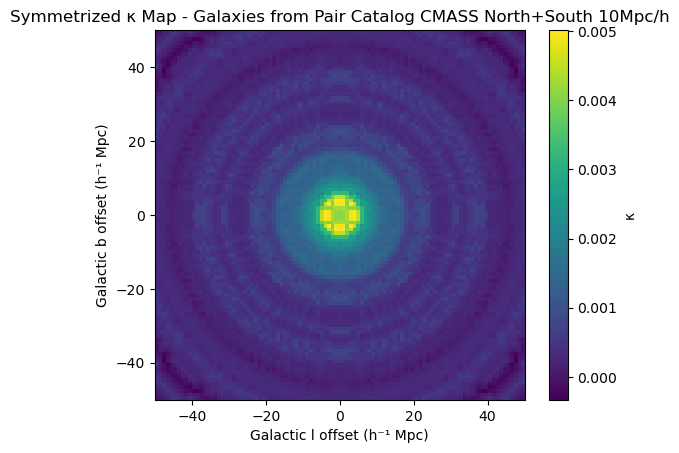

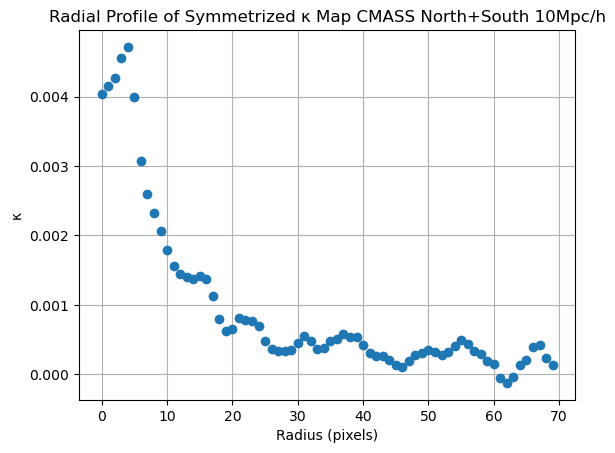

(array([ 4.04438320e-03,  4.14985266e-03,  4.26840231e-03,  4.55053932e-03,
         4.71621098e-03,  3.98879490e-03,  3.06771432e-03,  2.59970569e-03,
         2.32947244e-03,  2.06635225e-03,  1.79539903e-03,  1.55710080e-03,
         1.43670085e-03,  1.39526032e-03,  1.37545357e-03,  1.40849746e-03,
         1.36545548e-03,  1.13345712e-03,  7.97949438e-04,  6.21029117e-04,
         6.58309423e-04,  8.06358532e-04,  7.85147545e-04,  7.66060399e-04,
         6.90256328e-04,  4.72922464e-04,  3.67751481e-04,  3.38072778e-04,
         3.27080631e-04,  3.52984956e-04,  4.48548800e-04,  5.50176055e-04,
         4.75168511e-04,  3.66638830e-04,  3.73875417e-04,  4.83166287e-04,
         5.12818833e-04,  5.80981931e-04,  5.39294422e-04,  5.38456965e-04,
         4.13649939e-04,  3.05636012e-04,  2.61299097e-04,  2.61159349e-04,
         2.10773249e-04,  1.39081859e-04,  1.07533279e-04,  1.88839094e-04,
         2.77952466e-04,  3.08577599e-04,  3.43600973e-04,  3.25476408e-04,
         2.7

In [10]:
plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title(f"Symmetrized κ Map - Galaxies from Pair Catalog {catalog} {region} {distance}Mpc/h")
plt.show()

# --- Plot radial profile ---
radial_profile(kappa_sym, title=f"Radial Profile of Symmetrized κ Map {catalog} {region} {distance}Mpc/h", zoom=70)

In [11]:
# The next section explores reflection symmetry enforcement
# The next graph is the one that I attached to the google doc

In [12]:
def reflect_symmetrize_map(kappa_map):
    """
    Apply reflection symmetry: for every (x,y), average values at
    (+/-x, +/-y) and assign the average to all four.
    Assumes kappa_map is square with odd dimensions (so center is defined).
    """
    sym_map = np.copy(kappa_map)
    n = kappa_map.shape[0]
    center = n // 2  # integer index of the center pixel

    for i in range(center + 1):       # only need to loop half
        for j in range(center + 1):
            # Offsets from the center
            di, dj = i - center, j - center

            # Four symmetric positions
            coords = [
                (center + di, center + dj),
                (center - di, center + dj),
                (center + di, center - dj),
                (center - di, center - dj),
            ]

            # Extract values
            vals = [kappa_map[x, y] for x, y in coords]

            # Compute mean
            avg_val = np.mean(vals)

            # Assign average back
            for x, y in coords:
                sym_map[x, y] = avg_val

    return sym_map

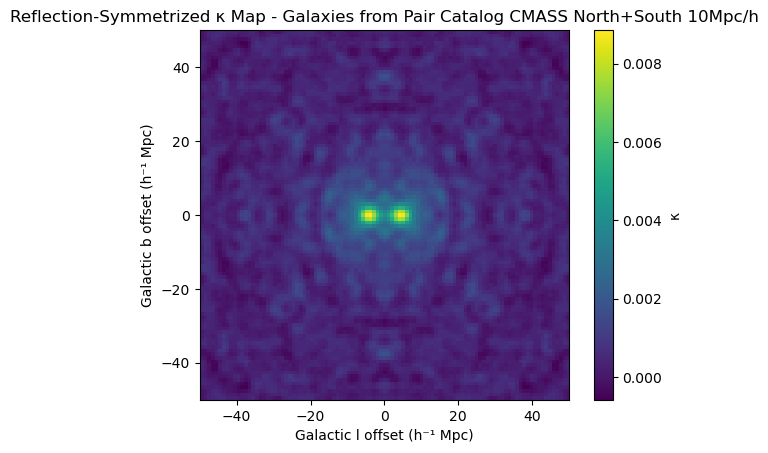

In [13]:
# --- Plot symmetrized map (reflection symmetry) ---
kappa_sym = reflect_symmetrize_map(kappa_stack_mean)
plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title(f"Reflection-Symmetrized κ Map - Galaxies from Pair Catalog {catalog} {region} {distance}Mpc/h")
plt.show()

In [14]:
pd.DataFrame(kappa_sym).to_csv(fr"data/kappa_sym_{distance}_BOSS_NGCSGC.csv", index=True)

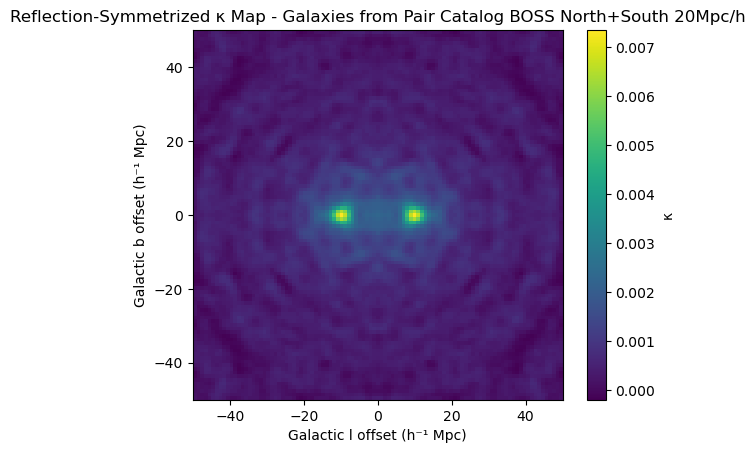

In [5]:
import numpy as np
import healpy as hp
from astropy.cosmology import Planck18 as cosmo
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm  # progress bar

extent = [-half_size, half_size, -half_size, half_size]

kappa_sym = pd.read_csv(fr"data/kappa_sym_20_BOSS_NGCSGC.csv", index_col=0).to_numpy()
plt.imshow(kappa_sym, origin='lower', extent=extent, cmap='viridis')
plt.colorbar(label='κ')
plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
plt.title(f"Reflection-Symmetrized κ Map - Galaxies from Pair Catalog BOSS North+South {distance}Mpc/h")
plt.show()